In [184]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import os

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import pandas as pd
import os
from glob import glob


def compute_baseline_mask(
    df,
    gas,
    signal_col=None,
    baseline_eps=0.01,
    use_iqr=True,
    use_isolation=False,
    contamination=None,
    verbose=False
):
    """
    Универсальная функция для расчёта baseline-маски (bl) для одного газа.
    df            — DataFrame с данными
    gas           — имя газа ('NO2', 'SO2', ...)
    signal_col    — имя сигнальной колонки (по умолчанию f'{gas}op1')
    baseline_eps  — допустимый уровень "нуля" для концентрации газа
    use_iqr       — использовать ли IQR-фильтрацию по сигналу
    use_isolation — использовать ли IsolationForest для мультифакторной фильтрации
    contamination — доля выбросов для IsolationForest (если None — автооценка по IQR)
    verbose       — печатать ли статистику
    """
    from sklearn.ensemble import IsolationForest

    if signal_col is None:
        signal_col = f"{gas}op1"
    temp_col = f"{gas}t"

    # 1. Простейший baseline по концентрации газа
    valid_mask = df[signal_col].notna()
    bl_mask = (df[gas].fillna(0) < baseline_eps) & valid_mask

    if use_iqr:
        q1 = df.loc[bl_mask, signal_col].quantile(0.25)
        q3 = df.loc[bl_mask, signal_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        iqr_mask = df[signal_col].between(lower, upper)
        bl_mask = bl_mask & iqr_mask

    if use_isolation:
        features = [signal_col]
        if temp_col in df: features.append(temp_col)
        if 'MH' in df: features.append('MH')
        if f"{temp_col}_grad" in df: features.append(f"{temp_col}_grad")
        if 'MH_grad' in df: features.append('MH_grad')
        iso_df = df.loc[bl_mask, features].dropna()
        if not iso_df.empty:
            # Оцениваем contamination по IQR, если не задано явно
            if contamination is None and use_iqr:
                extreme = (df.loc[bl_mask, signal_col] < lower) | (df.loc[bl_mask, signal_col] > upper)
                contamination_est = min(max(extreme.sum() / len(extreme), 0.001), 0.2)
            else:
                contamination_est = contamination if contamination is not None else 0.02
            if verbose:
                print(f"{gas}: estimated contamination = {contamination_est:.4f}")
            iso = IsolationForest(contamination=contamination_est, random_state=42)
            outliers = iso.fit_predict(iso_df)
            bad_idx = iso_df.index[outliers == -1]
            bl_mask.loc[bad_idx] = False

    if verbose:
        print(f"{gas}: {bl_mask.sum()} baseline (после фильтрации)")

    return bl_mask




def plot_data(df, filename,
              plot_blocks=None,
              start_date=None,
              end_date=None):
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.ticker import MaxNLocator

    def plot_column(ax, df, col, linewidth=2.0):
        if col not in df.columns or df[col].dropna().empty:
            return
        is_bool_col = df[col].dropna().isin([0, 1, True, False]).all()
        if is_bool_col:
            x = df['date']
            y1 = np.zeros(len(df))
            y2 = np.full(len(df), 0.8)
            mask = df[col].astype(bool).fillna(False).values
            if len(x) == len(mask):
                ax.fill_between(x, y1, y2, where=mask,
                                color='orange', alpha=0.3, transform=ax.get_xaxis_transform(), label=col)
        else:
            ax.plot(df['date'], pd.to_numeric(df[col], errors='coerce'), label=col, linewidth=linewidth)



    # df['date'] = pd.to_datetime(df['date'])

    if start_date:        
        df = df[df['date'] >= start_date]
    if end_date:  
        df = df[df['date'] <= end_date]

    if plot_blocks is None:
        plot_blocks = [[], [], [], []]
    elif len(plot_blocks) < 4:
        plot_blocks += [[]] * (4 - len(plot_blocks))
    plot_blocks = [[col for col in group if col in df.columns] for group in plot_blocks]

    fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
    for i, ax in enumerate(axes):
        for col in plot_blocks[i]:
            plot_column(ax, df, col)
        if plot_blocks[i]:
            ax.legend(loc='upper left', bbox_to_anchor=(1.12, 1), title=f'Group {i+1}')

    time_span = df['date'].max() - df['date'].min()
    days = time_span.days
    hours = time_span.total_seconds() / 3600

    if days > 30:
        major_locator = mdates.MonthLocator()
        minor_locator = mdates.WeekdayLocator(interval=1)
        major_formatter = mdates.DateFormatter('%d %b\n%Y')
    elif days >= 2:
        major_locator = mdates.DayLocator(interval=max(1, days // 7))
        minor_locator = mdates.DayLocator()
        major_formatter = mdates.DateFormatter('%d %b')
    elif hours >= 6:
        major_locator = mdates.HourLocator(interval=max(1, int(hours / 6)))
        minor_locator = mdates.HourLocator(interval=1)
        major_formatter = mdates.DateFormatter('%H:%M\n%d %b')
    else:
        major_locator = mdates.MinuteLocator(byminute=range(0, 60, 15))
        minor_locator = mdates.MinuteLocator(byminute=range(0, 60, 5))
        major_formatter = mdates.DateFormatter('%H:%M')

    for ax in axes:
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_formatter)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.tick_params(axis='x', which='major', labelsize=9)
        ax.tick_params(axis='x', which='minor', length=4, color='gray')
        ax.yaxis.set_major_locator(MaxNLocator(6))
        ax.grid(True, which='both', axis='x', alpha=0.3)
        ax.grid(True, axis='y', alpha=0.3)

    fig.suptitle(filename, y=1.03, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)
    plt.show()


def read_data(path, filename, delete_nans=False, add_stat=False, add_bl=False, add_reference=False, verbose=True, gases=None, std_thr=0.1, window=5):
    if add_stat and not add_bl:
        print("Warning: add_stat=True возможно только при add_bl=True! Принудительно add_bl=True.")
        add_bl = True
        
    if gases is None:
        gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']

    df = pd.read_csv(f'{path}/{filename}')
    # display(df)
    if verbose:
        print(f"all data length = {len(df)}")
    if 'ts' in df.columns:
        df = df.drop(columns=['ts'])

    # Удаление полностью пустых колонок
    for col in df.columns:
        if df[col].isna().sum() == len(df):
            df = df.drop(columns=col)
            if verbose:
                print(f"column {col} was deleted (all NaNs)")

    # Удаление полностью пустых строк 
    if delete_nans:
        cols_to_check = [col for col in df.columns if col != 'date']
        rows_to_delete = df[cols_to_check].isna().all(axis=1).sum()
        if verbose:
            print(f"Будет удалено строк: {rows_to_delete}")
        df = df.dropna(subset=cols_to_check, how='all')

    if verbose:
        print(f"final data length = {len(df)}")



    for gas in gases:
        if gas in df.columns and f"{gas}op1" in df.columns:
            if add_bl:
                df[f"{gas}op1_bl"] = compute_baseline_mask(
                    df, gas,
                    baseline_eps=0.01,
                    use_iqr=True,
                    use_isolation=False,
                    verbose=verbose
                )

            if add_stat:
                signal = df[f"{gas}op1"]
                stat_mask = signal.rolling(window, center=True).std() < std_thr
                df[f"{gas}op1_stat"] = stat_mask.fillna(False) & (~df[f"{gas}op1_bl"])           
        else:
            if add_bl:
                df[f"{gas}op1_bl"] = False
            if add_stat:
                df[f"{gas}op1_stat"] = False

    
    # --- REFERENCE START ---
    if add_reference:
        import os
        path_ref = os.path.join(os.path.dirname(path), "field_reference")
        for gas in ['NO2', 'O3']:
            ref_file = os.path.join(path_ref, f"{gas}_ref.csv")
            print('Ищу:', ref_file, '— найден:', os.path.exists(ref_file))
            if os.path.exists(ref_file):
                df_ref = pd.read_csv(ref_file) 
                if 'date' not in df_ref.columns:
                    continue
                df_ref['date'] = pd.to_datetime(df_ref['date'])
                value_cols = [col for col in df_ref.columns if col != 'date']
                if value_cols:
                    val_col = value_cols[0]
                    ref_col_name = f"{gas}_ref"
                    df_ref = df_ref.rename(columns={val_col: ref_col_name})
                    df['date'] = pd.to_datetime(df['date'])
                    df = pd.merge(df, df_ref[['date', ref_col_name]], on='date', how='left')
    # --- REFERENCE END ---

    types = {
        'bool': [],
        'small': [],
        'middle': [],
        'large': []
    }
    numeric_cols = [col for col in df.columns if col != 'date' and pd.api.types.is_numeric_dtype(df[col])]
    for col in numeric_cols:
        values = df[col].dropna()
        if values.empty:
            continue
        unique_vals = set(values.unique())
        mean_val = values.mean()
        std_val = values.std()
        if unique_vals <= {0, 1}:
            types['bool'].append(col)
        elif mean_val > 100 or std_val > 50:
            types['large'].append(col)
        elif std_val > 10:
            types['middle'].append(col)
        else:
            types['small'].append(col)
    if verbose:
        print("\n[Типизация переменных]")
        for key, val in types.items():
            print(f"{key.upper():>6}: {val}")

        
    print(df.columns)
    return df, types



# path  = "data_example/lab_data"
path_ref  = "data_example/field_reference"
path  = "data_example/field_data"
file_list = sorted([os.path.basename(f) for f in glob(os.path.join(path, "*.csv"))])
file_iter = iter(file_list)


Ищу: data_example\field_reference\NO2_ref.csv — найден: True
Ищу: data_example\field_reference\O3_ref.csv — найден: True
Index(['date', 'CO', 'NO2', 'O3', 'NO2op1', 'NO2op2', 'NO2t', 'O3op1', 'O3op2',
       'O3t', 'COop1', 'COop2', 'COt', 'g1_mt', 'g1_mh', 'NO2_ref', 'O3_ref'],
      dtype='object')


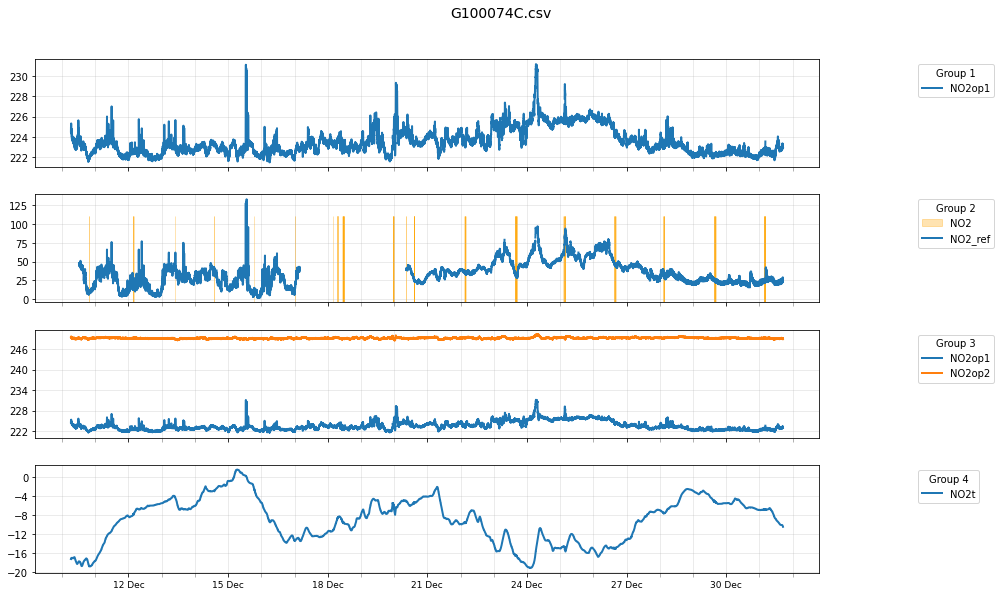

In [ ]:

try:
    filename = next(file_iter)
    # filename ='G200075С.csv'  # нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная
    # filename ='G10008A4.csv'  # нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная (нули с эпизодическими скачками)
    # filename ='G10005DA.csv'  присутсвуют длит. периоды без данных
    # filename ='G10006DB.csv'  присутсвуют длит. периоды без данных
    # filename ='G10009DB.csv'  много дрифтов

    df, types = read_data(path, filename=filename, delete_nans=False, verbose=False, add_reference=True, add_stat = False, std_thr=0.5, window=5)
    start_date = df['date'].min()
    end_date = df['date'].max()
    start_date = '2024-12-10 13:25:00'
    # end_date =  '2024-05-28 17:25:00'

    # df['date'] = pd.to_datetime(df['date'])  
    df['date'] = pd.to_datetime(df['date'])
    freq = 'min'  # или 'H'
    full_range = pd.date_range(df['date'].min(), df['date'].max(), freq=freq)
    df = df.set_index('date').reindex(full_range).rename_axis('date').reset_index()

    tz = df['date'].dt.tz
    sd = pd.to_datetime(start_date)
    ed = pd.to_datetime(end_date)
    if tz is not None:
        if sd.tzinfo is None: sd = sd.tz_localize(tz)
        else: sd = sd.tz_convert(tz)
        if ed.tzinfo is None: ed = ed.tz_localize(tz)
        else: ed = ed.tz_convert(tz)



    # gas = 'SO2'
    # cols_1 = [f'{gas}op1_stat_auto', f'{gas}op1', f'{gas}op2', 'O3']
    # cols_1 = [f'{gas}op1', f'{gas}op2']
    # cols_2 = [gas]
    # cols_3 = ['g1_mh', 'NO2op1_stat']
    # cols_4 = [f'{gas}t', 'stat']
    cols_1 = []
    cols_2 = []
    cols_3 = []
    cols_4 = []

    gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']
    gases = ['NO2']

    # gases = [ 'CO', 'O3', 'SO2', 'H2S']

    # gases = ['NO2', 'O3', 'SO2', 'H2S']
    # gases = ['NO2',  'SO2', 'H2S']
    for gas in gases:
        if f'{gas}op1' in df.columns:
            cols_1.append(f'{gas}op1')
        # if f'{gas}op2' in df.columns:
            # cols_1.append(f'{gas}op2')
        if gas in df.columns:
            cols_2.append(gas)
        if f'{gas}t' in df.columns:
            cols_4.append(f'{gas}t')
    if 'g2_mh' in df.columns:
        cols_3.append('g2_mh')
    if 'g2_mt' in df.columns:
        cols_3.append('g2_mt')
    if 'g1_mh' in df.columns:
        cols_3.append('g1_mh')
    if 'g1_mt' in df.columns:
        cols_3.append('g1_mt')
    if 'stat' in df.columns:
        cols_4.append('stat')

    cols_3 = ['NO2op1','NO2op2','MH']
    
    cols_2 += [col for col in ['NO2_ref', 'O3_ref'] if col in df.columns]


    plot_data(
        df,
        filename=filename,
        plot_blocks=[cols_1,cols_2,cols_3,cols_4], 
        start_date=start_date,
        end_date=end_date
    )

    
except StopIteration:
    print("Все файлы просмотрены!")

In [209]:
cols_2

['NO2', 'CO', 'O3', 'NO2_ref', 'O3_ref']

In [210]:
mask = (df['date'] >= sd) & (df['date'] <= ed)
display(df.loc[mask].head(50))



,date,CO,NO2,O3,NO2op1,NO2op2,NO2t,O3op1,O3op2,O3t,COop1,COop2,COt,g1_mt,g1_mh,NO2_ref,O3_ref
0,2024-09-27 15:38:00+07:00,0.0,0.0,0.0,223.483,203.701,9.105,225.364,223.193,8.812,34.634,28.716,9.153,9.75,41.05,24.0,46.0
1,2024-09-27 15:39:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,45.0
2,2024-09-27 15:40:00+07:00,0.0,0.0,0.0,224.705,205.313,9.061,226.648,224.164,8.765,34.512,28.595,9.098,9.68,41.30,28.0,45.0
3,2024-09-27 15:41:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,41.0
4,2024-09-27 15:42:00+07:00,0.0,0.0,0.0,226.501,207.821,8.959,228.864,225.893,8.680,33.866,28.423,8.996,9.59,41.56,26.0,43.0
5,2024-09-27 15:43:00+07:00,0.0,0.0,0.0,228.080,209.967,8.875,230.424,227.414,8.587,33.078,28.268,8.892,9.55,41.73,26.0,43.0
6,2024-09-27 15:44:00+07:00,0.0,0.0,0.0,228.080,209.967,8.875,230.424,227.414,8.587,33.078,28.268,8.892,9.51,41.89,24.0,45.0
7,2024-09-27 15:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,43.0
8,2024-09-27 15:46:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0
9,2024-09-27 15:47:00+07:00,0.0,0.0,0.0,229.960,212.345,8.750,232.511,229.085,8.468,32.879,28.079,8.750,9.40,42.34,26.0,49.0


In [211]:
import os
import pandas as pd
from glob import glob

# folder = "data_example/field_data"
# folder = "data_example/lab_data"
folder = "data_example/field_reference"

file_list = sorted([os.path.basename(f) for f in glob(os.path.join(folder, "*.csv"))])

summary = []
comments_dict = {
    'G200075C.csv': 'нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная (нули с эпизодическими скачками)',
    'G10008A4.csv': 'нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная (нули с эпизодическими скачками)',
    'G10005DA.csv': 'присутсвуют длит. периоды без данных',
    'G10006DB.csv': 'присутсвуют длит. периоды без данных',
    'G100096B.csv': 'много дрифтов'
}

comments_dict = {}

for filename in file_list:
    df = pd.read_csv(os.path.join(folder, filename))
    if 'date' not in df.columns:
        continue
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    if df['date'].notna().sum() == 0:
        continue
    min_date = df['date'].min().date()
    max_date = df['date'].max().date()
    comment = comments_dict.get(filename, "")

    summary.append({
        "start_date": min_date,
        "end_date": max_date,
        "file": filename,
        "comment": comment
    })

summary_df = pd.DataFrame(summary)

grouped = summary_df.groupby(['start_date', 'end_date'])

result_rows = []
for (start, end), group in grouped:
    for idx, row in group.iterrows():
        result_rows.append({
            "date_range": f"{start} — {end}" if idx == group.index[0] else "",
            "file": row['file'],
            "comment": row['comment']
        })

result_df = pd.DataFrame(result_rows)

display(result_df)

# result_df.to_excel("field_data_files_info.xlsx", index=False)
# result_df.to_excel("lab_data_files_info.xlsx", index=False)
# result_df.to_excel("field_reference_files_info.xlsx", index=False)


,date_range,file,comment
0,2024-01-01 — 2024-11-25,O3_ref.csv,
1,2024-03-19 — 2025-01-01,NO2_ref.csv,
